In [ ]:
# installation of Weights & Biases
!pip install wandb

In [ ]:
# Import of libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import random as rnd

%matplotlib inline

import wandb
import logging

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# wandb login
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1 - Import the file with trained model

In [ ]:
# starting a run in wandb
run = wandb.init(entity="flamigos", project="Murshroom-Kmeans", job_type="test")
# downloading the wandb model
artifact = run.use_artifact('flamigos/Murshroom-Kmeans/murshrooms_kmeans.plk:latest', type='modelo')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
# loading the model with the pickle
with open(artifact_dir + "/murshrooms_kmeans.plk", "rb") as f:
  loaded_model = pickle.load(f)

# 2 - Import the separate dataset for testing

In [ ]:
# download the latest version of the test.csv artifact
test = run.use_artifact('flamigos/Murshroom-Kmeans/test.csv:v0')

# create a dataframe from the artifact
df = pd.read_csv(test.file())

# 3 Identify outliers

In [ ]:
# temporary variable
x = df.select_dtypes("int64").copy()
x = x.join(df.select_dtypes("float64").copy())

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

## 3.1 remove outliers

In [ ]:
rm_outliers = df.loc[mask, :].copy()

# 4 - Separate the "class" column that contains the results (poisonous, edible) from the rest of the dataset

In [ ]:
# labels -> column of the results we want to obtain from the model
labels = rm_outliers["class"]

# get the other columns
columns = rm_outliers.keys()[1:]

# form a dataset with these columns
data = rm_outliers[columns]
data = data.values
data

array([[0, 2, 2, ..., 0, 2, 1],
       [4, 2, 3, ..., 4, 0, 1],
       [0, 2, 2, ..., 0, 0, 1],
       ...,
       [3, 2, 0, ..., 1, 4, 3],
       [0, 1, 0, ..., 4, 3, 3],
       [3, 2, 3, ..., 3, 3, 3]])

# 5 - Test the model and check accuracy

In [ ]:
t = loaded_model.predict(data)
t

array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

In [ ]:
# check accuracy
accuracy = accuracy_score(labels.values, t)
accuracy

0.847457627118644

In [ ]:
# close wandb run
run.finish()

# 6 - displaying the grouping result

## 6.1 results present in the dataset VS results obtained by clustering

In [ ]:
# number of values 1 and 0 in the test dataset
c = rm_outliers["class"].value_counts()
print(c)


# number of values 1 and 0 obtained by the model
filter0 = t == 0
r0 = t[filter0]
print(len(r0))

filter1 = t == 1
r1 = t[filter1]
print(len(r1))

1    823
0    770
Name: class, dtype: int64
683
910


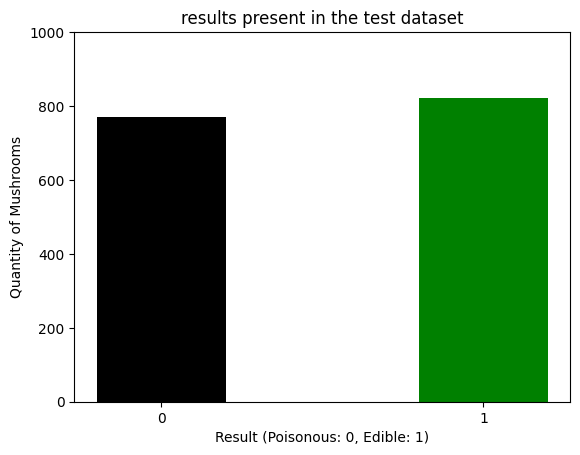

In [ ]:
fig, ax = plt.subplots()

ax.bar(c.index, c.values, color=['green', 'black'], align='center', width=0.4)

ax.set_xlabel('Result (Poisonous: 0, Edible: 1)')
ax.set_ylabel('Quantity of Mushrooms')
ax.set_title('results present in the test dataset')

ax.set_ylim(0, 1000)

ax.set_xticks([0, 1])

plt.show()


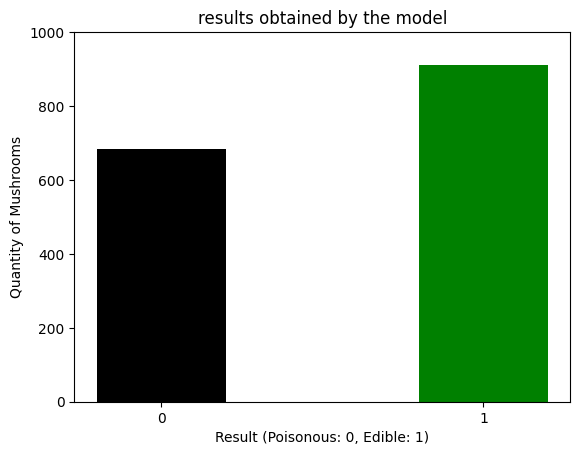

In [ ]:
fig, ax = plt.subplots()

ax.bar([1, 0], [len(r1), len(r0)], color=['green', 'black'], align='center', width=0.4)

ax.set_xlabel('Result (Poisonous: 0, Edible: 1)')
ax.set_ylabel('Quantity of Mushrooms')
ax.set_title('results obtained by the model')

ax.set_ylim(0, 1000)

ax.set_xticks([0, 1])

plt.show()

## 6.2 estimation of correct answers in model analysis

In [ ]:
# create an array with comparative values between the test data set and the model data set
# returns True when the value is equal
# returns False when they are different
comp = t == rm_outliers["class"]

# filter only hits -> True
acert = comp == True
a = comp[acert]
print(len(a))

# filter only errors -> False
err = comp == False
e = comp[err]
print(len(e))

1350
243


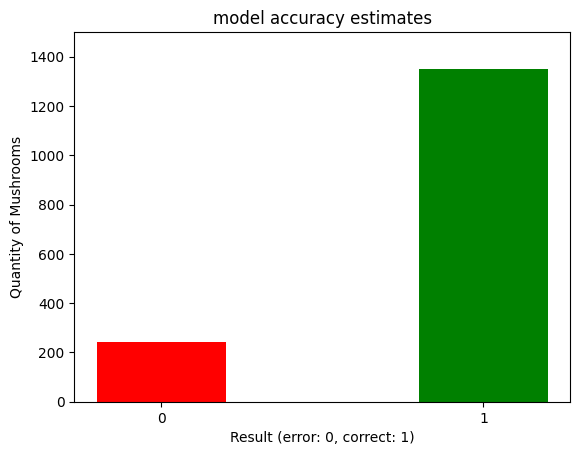

In [ ]:
fig, ax = plt.subplots()

ax.bar([1, 0], [len(a), len(e)], color=['green', 'red'], align='center', width=0.4)

ax.set_xlabel('Result (error: 0, correct: 1)')
ax.set_ylabel('Quantity of Mushrooms')
ax.set_title('model accuracy estimates')

ax.set_ylim(0, 1500)

ax.set_xticks([0, 1])

plt.show()

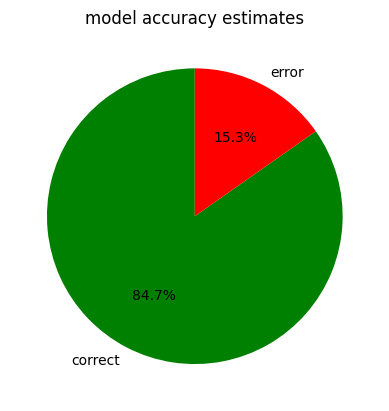

In [ ]:
# Create the pie chart
plt.pie([len(a), len(e)], labels=["correct", "error"], colors=['green', 'red'], autopct='%1.1f%%', startangle=90)

# Add title
plt.title('model accuracy estimates')

plt.show()